# Concept drifts

This notebook introduces concept drift detection, simulation and evaluation using CapyMOA. 

* There are more detailed notebooks and documentation available, see [CapyMOA tutorials](https://capymoa.org/tutorials.html) for more

---

*More information about CapyMOA, including how to install it, can be found in* https://www.capymoa.org

IJCAI 2024 tutorial. Jeju, South Korea (04/08/2024). Heitor Murilo Gomes, Nuwan Gunasekara, Albert Bifet, Bernhard Pfahringer

**Code examples are based on CapyMOA v0.6.0 as of 03/08/2024**

# 1. Simulating Concept Drifts

First, we demonstrate how to use the DriftStream API in CapyMOA to simulate concepts drifts. 
* We start by showing how one can use a synthetic generator without concept drift (RandomTreeGenerator)
* We delve into the DriftStream API, i.e. the **DriftStream Position**: **```drift position``` + ```drift width```**
* More advanced examples can be found in **Tutorial 6**: `Exploring Advanced Features`, such as configuring and manipulating MOA streams directly (See [CapyMOA tutorials](https://capymoa.org/tutorials.html))

### 1.1 CapyMOA synthetic generators

* In this example, we show how to use `RandomTreeGenerator` to generate a synthetic stream **without** concept drifts

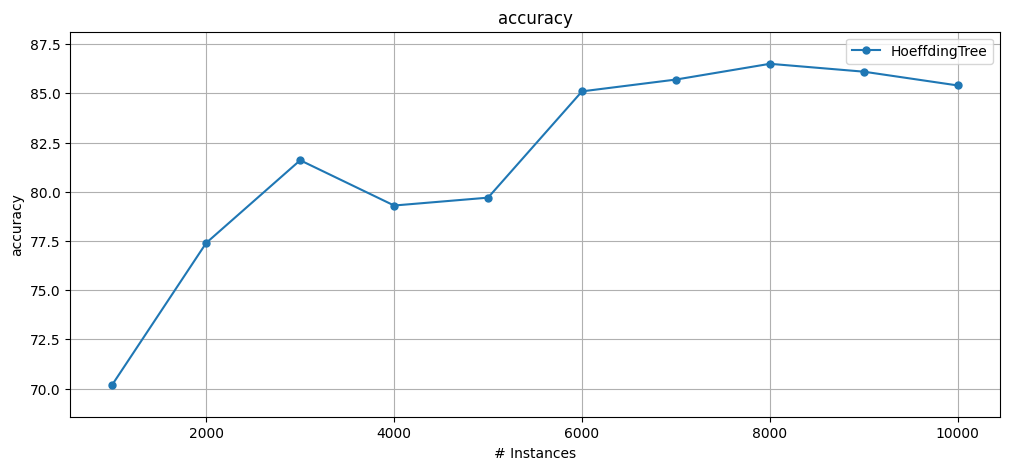

In [1]:
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import HoeffdingTree

rtg_stream = RandomTreeGenerator()

ht = HoeffdingTree(schema=rtg_stream.get_schema())

results_ht = prequential_evaluation(max_instances=10000, window_size=1000, stream=rtg_stream, learner=ht)

plot_windowed_results(results_ht, metric='accuracy')

## 1.1 CapyMOA DriftStream Builder API
  
In CapyMOA, the **concepts** and **drifts** are clearly outlined on a list format. Currently, there is one approach for specifying the list (another one is under construction i.e. the DriftStream Range API), i.e. the start and end of a concept is determined by the presence of an ```AbruptDrift``` or ```GradualDrift``` object: 

**```drift position + drift width```**: 
   
  <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(position=2000, width=500), SEA(3)]``` -->
  
  **DriftStream([**<span style="color:blue;">SEA(1)</span>, <span style="color:red;">AbruptDrift(position=1000)</span>, <span style="color:blue;">SEA(2)</span>, <span style="color:green;">GradualDrift(<b>position</b>=2000, <b>width</b>=500)</span>, <span style="color:blue;">SEA(3)</span>**])**

  The ```GradualDrift``` can also be specified in terms of ```start``` and ```end```.
  
  <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(start=1750, end=2250), SEA(3)]``` -->
  **DriftStream([**<span style="color:blue;">SEA(1)</span>, <span style="color:red;">AbruptDrift(position=1000)</span>, <span style="color:blue;">SEA(2)</span>, <span style="color:green;">GradualDrift(<b>start</b>=1750, <b>end</b>=2250)</span>, <span style="color:blue;">SEA(3)</span>**])**

* Some remarks: 
  * Why do we need the **```Concept()```** specification in the **```num_instances```**? The **Stream** class, i.e. base class for **SEA** and other synthetic generators do not implement the concept of a ```max_instances``` or ```num_instances```. If we were to implement that, we would lose compatibility with MOA (where such constraints doesn't exist) and would need to do some extra checks when generating streams. 
  * The **```DriftStream```** specification in the ```position``` + ```width``` version does not specify the total ```size``` of the stream, i.e. notice how the SEA(3) at the end is unbounded, there is no Drift object signaling its end. That is intentional, the user specifying the DriftStream and manipulating it defines the end of the Stream externally. This is true for synthetic streams and also for limiting *snapshot* streams like **electricity** and others that are read from files. 


### 1.2 DriftStream prelude: the raw MOA version

* We first show how it is done using MOA's API, so that one can compare it with CapyMOA syntax
* We simulate the following drifting stream using a traditional recursive MOA syntax

```sh
SEA(function=1), Drift(position=5000, width=1000), SEA(function=2), Drift(position=10000, width=2000), SEA(function=3)
```

* The CLI below is _easy_ to configure in the MOA GUI, but it can lead to issues when specified directly on the CLI

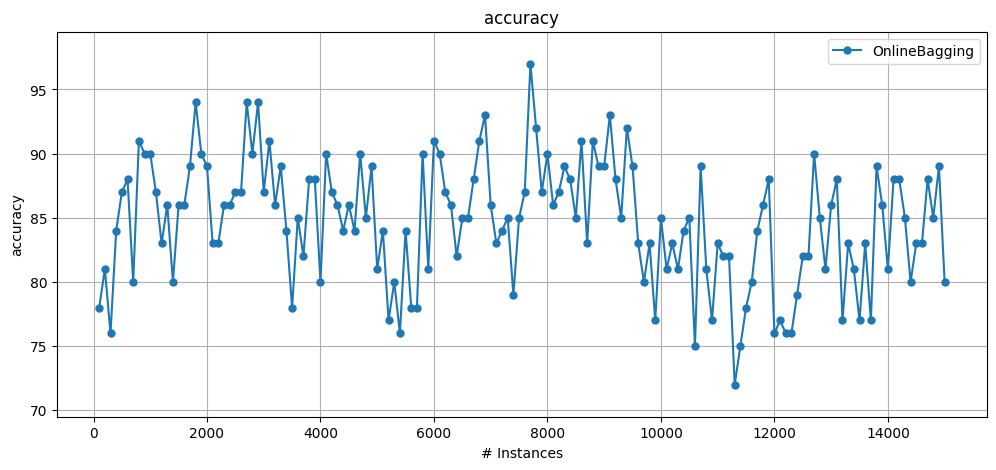

In [2]:
from capymoa.classifier import OnlineBagging
from capymoa.stream import Stream
from moa.streams import ConceptDriftStream

stream_sea2drift = Stream(moa_stream=ConceptDriftStream(), 
    CLI="-s (ConceptDriftStream -s (generators.SEAGenerator -f 1) -d (generators.SEAGenerator -f 2) -p 5000 -w 1) -d (generators.SEAGenerator -f 3) -p 10000 -w 2000")

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

plot_windowed_results(results_sea2drift_OB, metric='accuracy')

### 1.3 DriftStream ```position``` + ```width```

* We can use either `position + width` or `start + end` to define GradualDrifts in this approach.

  ```sh
  GradualDrift(position=10000, width=2000)
  ```
  or
  ```sh
  GradualDrift(start=9000, end=12000)
  ```
* **Important**: meta-data about the specified Drifts is accessible from the stream object

```python
print(f'The definition of the DriftStream is accessible through the object:\n {stream_sea2drift}')
```

* Furthermore, this meta-data is interpreted by the `plot_windowed_results` function producing plots that automatically indicates drift locations. 

The definition of the DriftStream is accessible through the object:
 SEA(function=1),AbruptDrift(position=5000),SEA(function=3),GradualDrift(position=10000, start=9000, end=11000, width=2000),SEA(function=1)


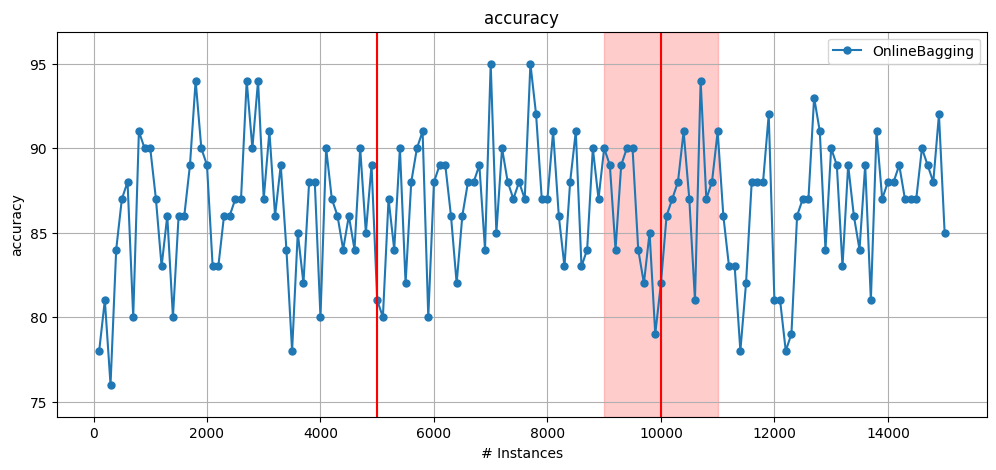

In [3]:
from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift
from capymoa.stream.generator import SEA

stream_sea2drift = DriftStream(stream=[SEA(function=1), 
                                AbruptDrift(position=5000), 
                                SEA(function=3), 
                                GradualDrift(position=10000, width=2000), 
                                # GradualDrift(start=9000, end=12000),
                                SEA(function=1)])

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

print(f'The definition of the DriftStream is accessible through the object:\n {stream_sea2drift}')
plot_windowed_results(results_sea2drift_OB, metric='accuracy')

#### 1.3.1 Obtaining meta-data about drift from a MOA Stream

* Besides composing a drifting stream, the DriftStream object also holds information about the Drifts. 
* The meta-data about the drifts can be used for quickly investigating where and how many `Drifts` a particular `Stream` object has associated with it.

* It is doable to extract drifting information from the MOA ConceptDriftStream objects, precisely the Stream objects that form the concepts for a proper printing. However, that has not been implemented yet as it is a bit cumbersome. So, for the moment, when a DriftStream is specified based on a MOA CLI, we just return the CLI used when we attempt to print the object (see below)

```python
print(stream_sea2drift)
```

* However, the information is available and can be accessed through the `get_drifts()` method as we exemplify below

```python
for drift in stream_sea2drift.get_drifts():
    print(f'\t{drift}')
```

Attempting to print a stream from a raw MOA ConceptDriftStream: ConceptDriftStream -s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1)                                -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0

Now, an example on how to access individual drifts from a DriftStream:
	AbruptDrift(position=5000)
	GradualDrift(position=10000, width=200)


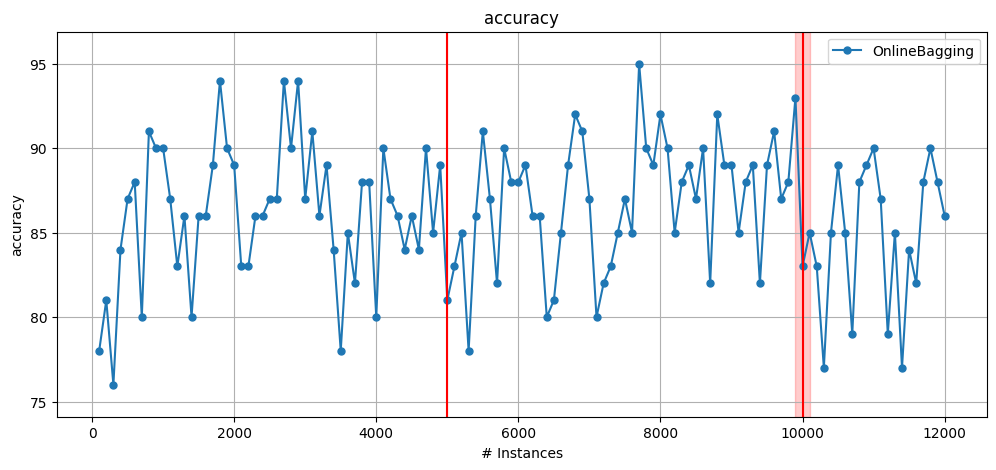

In [4]:
from moa.streams import ConceptDriftStream

stream_sea2drift = DriftStream(moa_stream=ConceptDriftStream(), 
                               CLI='-s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1) \
                               -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0')

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=12000)

print(f'Attempting to print a stream from a raw MOA ConceptDriftStream: {stream_sea2drift}')
print('\nNow, an example on how to access individual drifts from a DriftStream:')
for drift in stream_sea2drift.get_drifts():
    print(f'\t{drift}')
# Notice it works just fine to plot and use the DriftStream created using a MOA object. 
plot_windowed_results(results_sea2drift_OB, metric='accuracy')

## 1.4 Recurrent Drifts using DriftStream

In this example, we configure stream with recurrent concepts using the `DriftStream` API

* This is a very flexible way of specifying the recurrent concept drifts, but we need to specify all the concepts and drift transitions, which is a bit tedious. 

* More information about recurrent concept drifts:
  * **Recurrent Concept Drifts on Data Streams.** Nuwan Gunasekara, Bernhard Pfahringer, Heitor Murilo Gomes, Albert Bifet, Yun Sing Koh. IJCAI 2024 (12 min. talk | August 6th at 15:00 | Session: ML: Machine Learning (1/6))


Meta data for the recurrent concept stream:
SEA(function=1),AbruptDrift(position=2000),SEA(instance_random_seed=2, function=1),AbruptDrift(position=4000),SEA(instance_random_seed=3, function=1),AbruptDrift(position=6000),SEA(function=1),AbruptDrift(position=8000),SEA(instance_random_seed=2, function=1),AbruptDrift(position=10000),SEA(instance_random_seed=3, function=1)


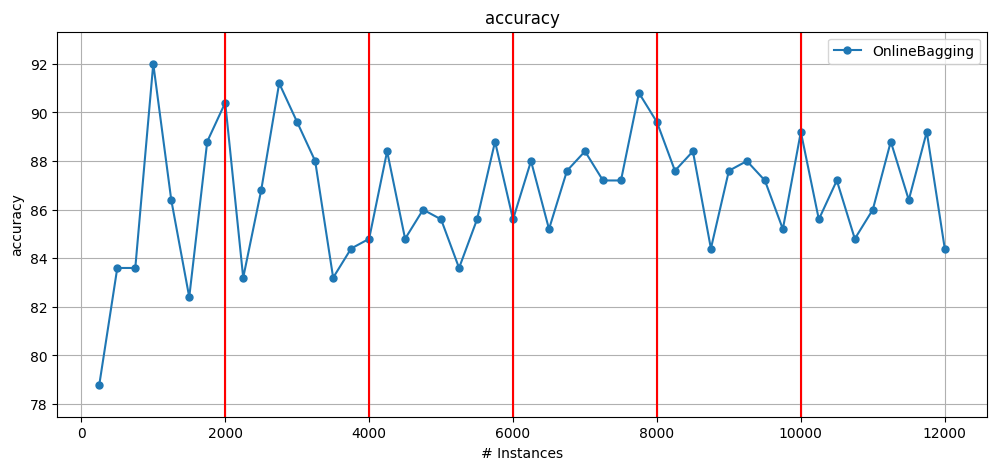

In [5]:
from capymoa.stream.drift import DriftStream, AbruptDrift
from capymoa.stream.generator import SEA
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

window_size = 250
concept_length = 2000
max_instances = concept_length*6

stream_with_drifts = DriftStream(stream=[
                                SEA(1), AbruptDrift(position=concept_length*1),
                                SEA(2), AbruptDrift(position=concept_length*2),
                                SEA(3), AbruptDrift(position=concept_length*3),
                                SEA(1), AbruptDrift(position=concept_length*4),
                                SEA(2), AbruptDrift(position=concept_length*5),
                                SEA(3),
                                ])

OB = OnlineBagging(schema=stream_with_drifts.get_schema(), ensemble_size=10)

results_stream_with_drifts_OB = prequential_evaluation(stream=stream_with_drifts, learner=OB, window_size=window_size, max_instances=max_instances)

print(f'Meta data for the recurrent concept stream:\n{stream_with_drifts}')
plot_windowed_results(results_stream_with_drifts_OB, metric='accuracy')

### 1.4.1 Recurrent Drifts using RecurrentConceptDriftStream

* In this example, we use a special class to specify the drifts, i.e. `RecurrentConceptDriftStream` instead of the `DriftStream` class. 

* `RecurrentConceptDriftStream` adds concept meta information that indicates the concepts, which is useful for evaluation of methods that cope with recurrent concept drifts and for visualization as it integrates with `plot_windowed_results()`. 

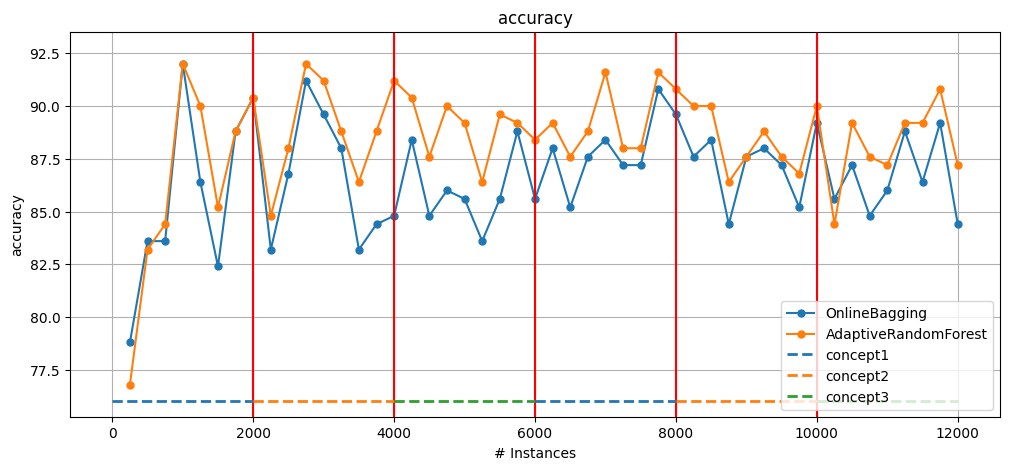

In [6]:
from capymoa.stream.drift import AbruptDrift, RecurrentConceptDriftStream
from capymoa.stream.generator import SEA
from capymoa.classifier import OnlineBagging, AdaptiveRandomForestClassifier
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results  

concept1 = SEA(1)
concept2 = SEA(2)
concept3 = SEA(3)


window_size = 250
concept_length = 2000
concept_list = [concept1, concept2, concept3]
concept_name_list = ['concept1', 'concept2', 'concept3']
max_recurrences_per_concept = 2
max_instances = concept_length * len(concept_list) * max_recurrences_per_concept

stream_with_recurrent_concepts = RecurrentConceptDriftStream(concept_list=concept_list,
                                               max_recurrences_per_concept=max_recurrences_per_concept,
                                               transition_type_template=AbruptDrift(position=concept_length),
                                               concept_name_list=concept_name_list
                                               )

OB = OnlineBagging(schema=stream_with_recurrent_concepts.get_schema(), ensemble_size=10)

arf = AdaptiveRandomForestClassifier(schema=stream_with_recurrent_concepts.get_schema(), ensemble_size=10)

results_stream_with_drifts_OB = prequential_evaluation(stream=stream_with_recurrent_concepts, 
                                                       learner=OB, window_size=window_size, max_instances=max_instances)

results_stream_arf = prequential_evaluation(stream=stream_with_recurrent_concepts, 
                                                       learner=arf, window_size=window_size, max_instances=max_instances)

# print(f'Meta data for the recurrent concept stream:\n{stream_with_recurrent_concepts}')
# print(f'Recurrent concept stream MOA CLI: \n{stream_with_recurrent_concepts._CLI}')

plot_windowed_results(results_stream_with_drifts_OB, results_stream_arf, metric='accuracy')

## 2. Drift detection


In this part of the tutorial, we show how to performe drift detection using CapyMOA. 

First, we generated some dummy data:  

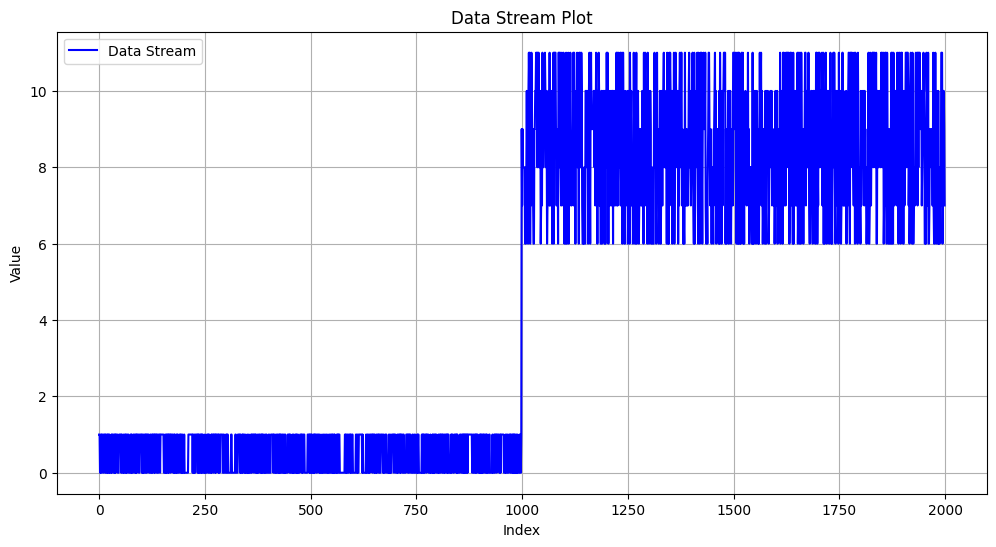

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generating the data stream
data_stream = np.random.randint(2, size=2000)
for i in range(999, 2000):
    data_stream[i] = np.random.randint(6, high=12)

# Creating a pandas DataFrame for easier plotting
df = pd.DataFrame(data_stream, columns=['value'])

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Data Stream', color='b')
plt.title('Data Stream Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


### 2.1 Trying all drift detectors

Now, we try all the drift detection algorithms available in CapyMOA (11 as of v0.6.0). 

In [3]:
from capymoa.drift import detectors
all_detectors = detectors.__all__

n_detections = {k: 0 for k in all_detectors}
for detector_name in all_detectors:

    detector = getattr(detectors, detector_name)()

    for i in range(2000):
        detector.add_element(float(data_stream[i]))
        if detector.detected_change():
            n_detections[detector_name] += 1

print(pd.Series(n_detections))

ADWIN                       2
CUSUM                       2
DDM                         1
EWMAChart                   1
GeometricMovingAverage      1
HDDMAverage               122
HDDMWeighted               82
PageHinkley                 1
RDDM                        1
SEED                        2
STEPD                       1
dtype: int64


### 2.2 ADWIN example

Now we proceed to one example using ADWIN


In [4]:
from capymoa.drift.detectors import ADWIN

adwin_detector = ADWIN(delta=0.001)

for i in range(2000):
    adwin_detector.add_element(data_stream[i])
    if adwin_detector.detected_change():
        print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))


Change detected in data: 10 - at index: 1023
Change detected in data: 8 - at index: 1119


## 2.3 Evaluating drift detectors

Assuming the drift locations are known, you can evaluate detectors using **EvaluateDetector** class

This class takes a parameter called **max_delay**, which is the maximum number of instances for which we consider a detector to have detected a change. After **max_delay** instances, we assume that the change is obvious and have been missed by the detector.

* Observation: We use the ADWIN detector from the previous example. 

In [5]:
from capymoa.drift.eval_detector import EvaluateDetector

dd_evaluator = EvaluateDetector(max_delay=200)

trues = np.array([1000])
# Obtain the detection locations from the
preds = adwin_detector.detection_index

dd_evaluator.calc_performance(preds, trues)

mean_time_to_detect           24.0
missed_detection_ratio         0.0
mean_time_btw_false_alarms     NaN
no_alarms_per_episode          0.0
dtype: float64